# Fox Survey Data
- _Note_: `sub-074` was mislabeled in the pre-test as `sub-073`. For now, I'm manually changing that in the raw data before importing it into the notebook.
- _Note_: `sub-001` was mislabeled in the pre-test. Changed manually

In [1]:
import pandas as pd
import datetime as dt
import os, sys, re
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

# Jin's code

In [ ]:
data_dir = os.path.abspath(os.path.join(os.getcwd(), '../data/surveys'))
today = dt.date.today()
date = today 
print(date)

In [ ]:
post_filename = f'fox-post_{date.strftime("%B")} {date.strftime("%-d")}, {date.strftime("%Y")}.csv'

post = pd.read_csv(os.path.join(data_dir, post_filename), skiprows=[1,2], encoding='utf-8-sig', parse_dates=[1,2], dayfirst=False)

conditions = {
    'LEGO': 1, 'BIG MOOD': 2, 'American Pickers': 3,
    'CNN News': 4, 'Continental': 5, 'Fox News': 6,
    'NFL': 7, 'YouTube TV': 8, 'YouTube - TV': 8,
    'Smartphone A - YouTube first': 9, 'Smartphone B - Facebook first': 10,
    'Control - TV': 11, 'Control - Smartphone': 12
}
conditions_normalized = {k.lower(): v for k, v in conditions.items()}

post['condition_normalized'] = post['condition'].str.strip().str.lower()
post['Cond'] = post['condition_normalized'].map(conditions_normalized)
post['Cond']

## Demographics

In [ ]:
demos = post[['ResponseId', 'Cond', 'condition', 'gender', 'age', 'glasses', 'race', 'education', 'income', 'politics']].copy()
demos['F'] = np.where(demos['gender'] == 2, 1, 0)
demos['M'] = np.where(demos['gender'] == 1, 1, 0)

demo_sum = demos.groupby('Cond').agg({
    'condition': ['size'],
    'age': ['min', 'mean', 'max', 'std'],
    'F': ['sum'],
    'M': ['sum']
}).round(2)

demo_sum_flat = pd.DataFrame(demo_sum.to_records())
demo_sum_flat.columns = ['Cond', 'Participants', 'Age_Min', 'Age_Mean', 'Age_Max', 'Age_Std', 'Female_Count', 'Male_Count']

conditions_swap = {v: k for k, v in conditions.items()}
demo_sum_flat['Cond'] = demo_sum_flat['Cond'].map(conditions_swap)

# Filter out conditions
demo_sum_filtered = demo_sum_flat[(demo_sum_flat["Cond"] != 'Control - Smartphone') & (demo_sum_flat["Cond"] != 'YouTube - TV')]

sns.set(style='whitegrid', context='talk')
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Participants per Condition
sns.barplot(
    x='Participants',
    y='Cond',
    data=demo_sum_filtered,
    palette='coolwarm',
    orient='h',
    ax=axs[0]
)
axs[0].set_xlabel('# of Participants', fontsize=18)
axs[0].set_ylabel('')
axs[0].set_title('Participants per Condition', fontsize=24)
axs[0].set_xlim(right=max(demo_sum_filtered['Participants']) + 2)

# Mean Age per Condition 
sns.barplot(
    x='Age_Mean',
    y='Cond',
    data=demo_sum_filtered,
    palette='coolwarm',
    orient='h',
    ax=axs[1],
    xerr=demo_sum_filtered['Age_Std']
)
axs[1].set_xlabel('Mean Age', fontsize=18)
axs[1].set_ylabel('')
axs[1].set_title('Mean Age per Condition', fontsize=24)
axs[1].set_xlim(right=max(demo_sum_filtered['Age_Mean']) + 5)

plt.tight_layout()
plt.show()


In [ ]:
demo_sum_filtered

In [ ]:
# Count the total number of participants by gender
demos = post[['ResponseId', 'gender']].copy()
gender_counts = demos['gender'].value_counts()
print(gender_counts)

gender_labels = {1: 'Male', 2: 'Female', 3: 'Non-binary / third gender'}
gender_counts.index = gender_counts.index.map(gender_labels)


plt.figure(figsize=(5, 5))
plt.pie(
    gender_counts,
    # labels=gender_counts.index,
    autopct='%1.1f%%',
    colors=sns.color_palette('coolwarm', len(gender_counts)),
    startangle=140
)
plt.title('Gender Proportion')
plt.axis('equal')  
plt.tight_layout()
plt.show()


## Brand Recall

In [ ]:
tv_conditions = ['LEGO', 'BIG MOOD', 'American Pickers', 'CNN News', 'Continental', 'Fox News', 'NFL']
social_media_conditions = ['Smartphone A - YouTube first', 'Smartphone B - Facebook first']

# Count recall data for each TV condition
tv_recall_counts = post[post['condition'].isin(tv_conditions)]['recall'].value_counts()

# Count recall data for each digital condition
social_media_recall_counts = post[post['condition'].isin(social_media_conditions)]['recall'].value_counts()
tv_recall_counts, social_media_recall_counts


In [ ]:
def count_brands(recall_data):
    brand_counts = Counter()
    for response in recall_data.dropna():
        brands = response.split(',')
        for brand in brands:
            brand_counts[brand.strip().lower()] += 1
    return brand_counts

# Count brands for TV conditions
tv_brand_counts = count_brands(post[post['condition'].isin(tv_conditions)]['recall'])

# Count brands for Social Media conditions
social_media_brand_counts = count_brands(post[post['condition'].isin(social_media_conditions)]['recall'])

tv_brand_counts, social_media_brand_counts


In [ ]:
standardization_map = {
    'red bull': ['red bull', 'redbull', 'red bull (juneberry)', 'red bulls', 'redbulls'],
    'paramount+': ['paramount+', 'paramount plus', 'paramount', 'paramoun+'],
    'burger king': ['burger king', 'burgerking', 'burger-king', 'burger kings', 'buger king'],
    'rakuten': ['rakuten', 'rakutu', 'rakutenn'],
    'chevy': ['chevy', 'chevrolet', 'chevorlet', 'chevvy', 'chev'],
    'samsung': ['samsung', 'sam sung', 'samsng', 'sumsung', 'sam-sung'],
    'tracfone': ['tracfone', 'trac-fone', 'tracfones'],
    'mounjaro': ['Mojourna', 'majaran', 'majorn', 'majoran', 'majoarn', 'majouran', 'Majaron', 'Manjara']
}

def standardize_recall_with_nan(recall_responses, standardization_map):
    standardized_responses = []
    for response in recall_responses:
        if pd.notna(response):
            standardized_response = []
            brands = response.split(',')
            for brand in brands:
                brand_cleaned = brand.strip().lower()
                standardized = False
                for standard_brand, variations in standardization_map.items():
                    if brand_cleaned in variations:
                        standardized_response.append(standard_brand)
                        standardized = True
                        break
                if not standardized:
                    standardized_response.append(brand_cleaned)  # Keep as is if no match found
            standardized_responses.append(','.join(standardized_response))
        else:
            standardized_responses.append(response)
    return standardized_responses

post['standardized_recall'] = standardize_recall_with_nan(post['recall'], standardization_map)
post[['recall', 'standardized_recall']]

In [ ]:
standardized_ads_list = list(standardization_map.keys())

# Function to create 0/1 values for recall of each ad
def create_recall_matrix_standardized(recall_data, ads):
    recall_matrix = pd.DataFrame(index=recall_data.index, columns=ads, data=0)
    for idx, row in recall_data.iterrows():
        if pd.notna(row['standardized_recall']):
            recalled_ads = [ad.strip().lower() for ad in row['standardized_recall'].split(',')]
            for ad in ads:
                if ad.lower() in recalled_ads:
                    recall_matrix.loc[idx, ad] = 1
    return recall_matrix

recall_matrix_standardized = create_recall_matrix_standardized(post[['id', 'condition', 'standardized_recall']], standardized_ads_list)
recall_matrix_standardized


In [ ]:
nested_recall_data_standardized = pd.concat([post[['id', 'condition']], recall_matrix_standardized], axis=1)

# Reshape the dataset to a long format
nested_recall = nested_recall_data_standardized.melt(id_vars=['id', 'condition'], 
                                                     value_vars=standardized_ads_list, 
                                                     var_name='ad', 
                                                     value_name='recall')

nested_recall = nested_recall[['id', 'condition', 'ad', 'recall']]
nested_recall

In [ ]:
# Group by 'sub' and 'condition' to repeat subject ID for each condition
nested_recall = nested_recall.groupby(['id', 'condition', 'ad']).agg(recall=('recall', 'sum')).reset_index()

nested_recall = nested_recall[['id', 'condition', 'ad', 'recall']]
nested_recall


In [ ]:
# Collapse the subjects within each condition
collapsed_recall = nested_recall.groupby(['condition', 'ad']).agg(
    recall_sum=('recall', 'sum'),
    recall_count=('recall', 'count')
).reset_index()

collapsed_recall['recall_rate'] = collapsed_recall['recall_sum'] / collapsed_recall['recall_count']
collapsed_recall

In [ ]:
tv_conditions = ['LEGO', 'BIG MOOD', 'American Pickers', 'CNN News', 'Continental', 'Fox News', 'NFL']
digital_conditions = ['Smartphone A - YouTube first', 'Smartphone B - Facebook first']

tv_recall_data = nested_recall[nested_recall['condition'].isin(tv_conditions)]
digital_recall_data = nested_recall[nested_recall['condition'].isin(digital_conditions)]

# Calculate the recall rates for each ad in TV conditions
tv_recall_rates = tv_recall_data.groupby('ad')['recall'].mean().reset_index()
tv_recall_rates.columns = ['ad', 'TV_Recall_Rate']

# Calculate the recall rates for each ad in digital conditions
digital_recall_rates = digital_recall_data.groupby('ad')['recall'].mean().reset_index()
digital_recall_rates.columns = ['ad', 'Digital_Recall_Rate']

recall_comparison = pd.merge(tv_recall_rates, digital_recall_rates, on='ad')
recall_comparison


In [ ]:
from scipy.stats import chi2_contingency

chi2_results = []
for ad in standardized_ads_list:
    # Create contingency table
    contingency_table = pd.crosstab(
        nested_recall[nested_recall['ad'] == ad]['condition'].isin(tv_conditions),
        nested_recall[nested_recall['ad'] == ad]['recall']
    )
    
    # Perform Chi-square test
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    chi2_results.append((ad, chi2_stat, p_val))

chi2_results_df = pd.DataFrame(chi2_results, columns=['ad', 'Chi2-Statistic', 'P-Value'])
chi2_results_df


# Liz' code

In [5]:
data_dir = os.path.abspath(os.path.join(os.getcwd(), '../data/surveys'))
today = dt.date.today()
date = today #.replace(day=today.day-1) #yesterday's data, change as needed
print(date)
# as long as you remove the time from the datasheet (##.##.csv), you don't need to manually change anything
# pre_filename = f'fox-pre_July+17.csv' 
post_filename = f'fox-post_October+15.csv' 

# pre = pd.read_csv(os.path.join(data_dir, pre_filename), skiprows=[1,2], encoding='utf-8-sig', parse_dates=[1,2], dayfirst=False)
post = pd.read_csv(os.path.join(data_dir, post_filename), skiprows=[1,2], encoding='utf-8-sig', parse_dates=[1,2], dayfirst=False)


2024-10-15


In [3]:
pre.condition.unique()

array(['Control - Smartphone', nan, 'LEGO', 'BIG MOOD',
       'American Pickers', 'CNN News', 'Continental', 'Fox News', 'NFL',
       'Control - TV', 'Smartphone A - YouTube first',
       'Smartphone B - Facebook first', 'Youtube - TV'], dtype=object)

In [6]:
post.condition.unique()

array(['Control - Smartphone', 'LEGO', 'BIG MOOD', 'American Pickers',
       'CNN News', 'Continental', 'Fox News', 'NFL', 'Control - TV',
       'Smartphone A - YouTube first', 'Smartphone B - Facebook first',
       'YouTube - TV', nan], dtype=object)

In [7]:
conditions = {
    'LEGO': 1, 'BIG MOOD': 2, 'American Pickers': 3,
    'CNN News': 4, 'Continental': 5, 'Fox News': 6,
    'NFL': 7, 'YouTube TV': 8, 'YouTube - TV': 8,
    'Smartphone A - YouTube first': 9, 'Smartphone B - Facebook first': 10,
    'Control - TV': 11, 'Control - Smartphone': 12
}
conditions_normalized = {k.lower(): v for k, v in conditions.items()}

# pre['condition_normalized'] = pre['condition'].str.strip().str.lower()
# pre['cond'] = pre['condition_normalized'].map(conditions_normalized)
post['condition_normalized'] = post['condition'].str.strip().str.lower()
post['cond'] = post['condition_normalized'].map(conditions_normalized)

## Demographics

### By Condition

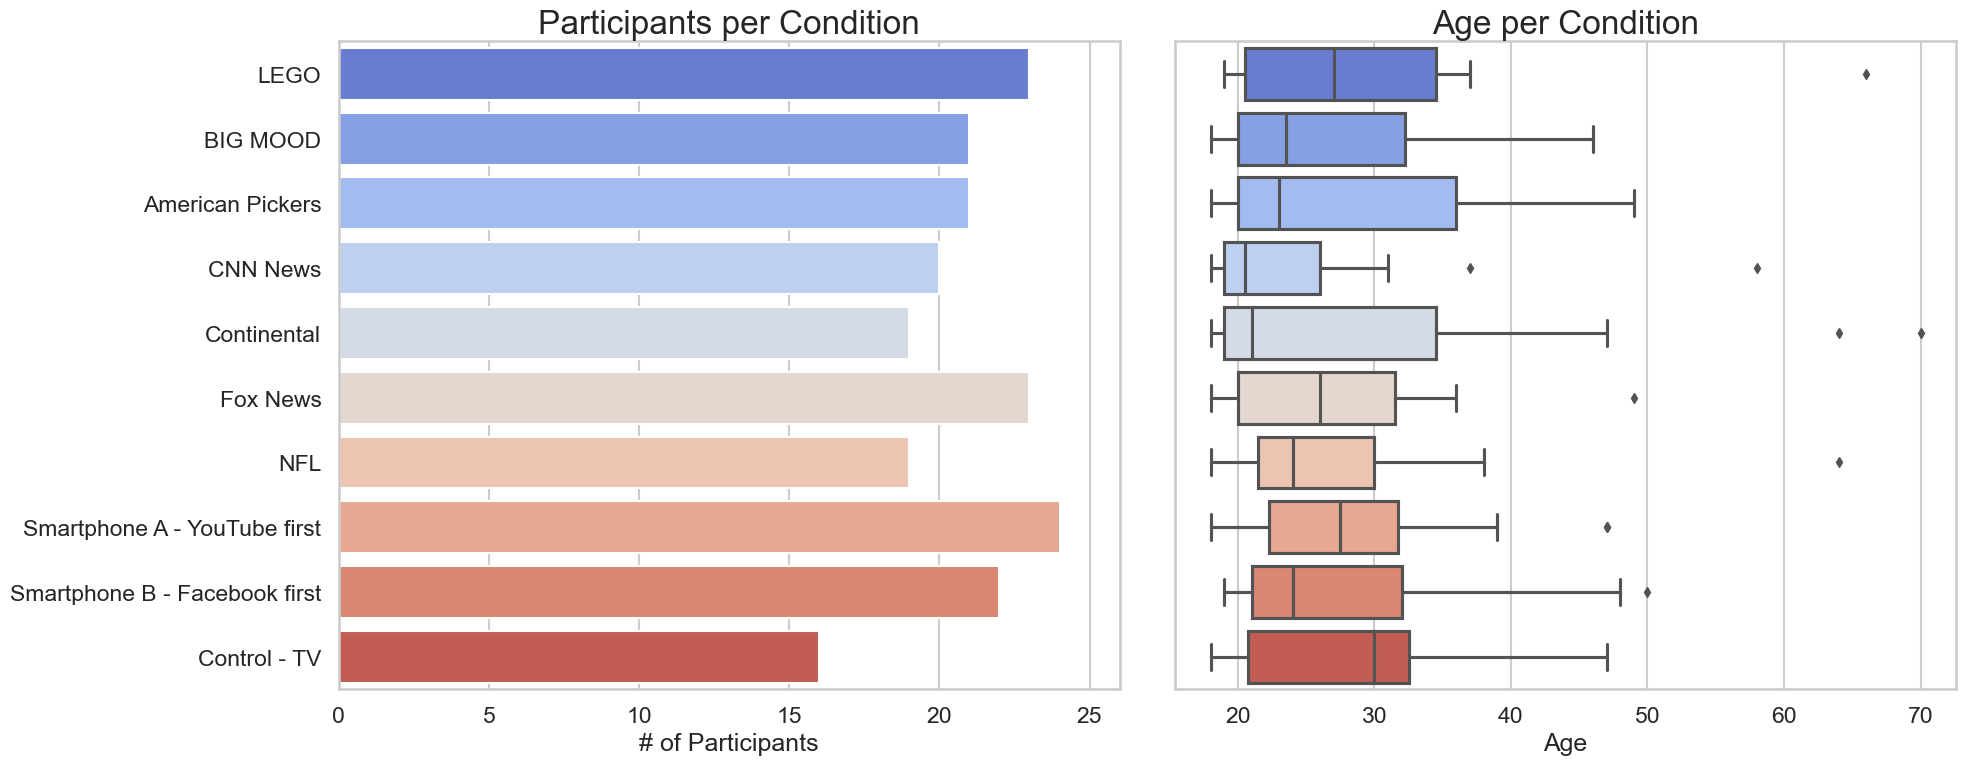

In [8]:
demos = post[['ResponseId', 'cond', 'condition', 'gender', 'age', 'glasses', 'race', 'education', 'income', 'politics']].copy()
demos['F'] = np.where(demos['gender'] == 'Female', 1, 0)
demos['M'] = np.where(demos['gender'] == 'Male', 1, 0)

demo_sum = demos.groupby('cond').agg({
    'condition': ['size'],
    'age': ['min', 'mean', 'max', 'std'],
    'F': ['sum'],
    'M': ['sum']
}).round(2)

demo_sum_flat = pd.DataFrame(demo_sum.to_records())
demo_sum_flat.columns = ['cond', 'Participants', 'Age_Min', 'Age_Mean', 'Age_Max', 'Age_Std', 'Female_Count', 'Male_Count']

conditions_swap = {v: k for k, v in conditions.items()}
demo_sum_flat['cond'] = demo_sum_flat['cond'].map(conditions_swap)

# Filter out conditions
demo_sum_filtered = demo_sum_flat[(demo_sum_flat["cond"] != 'Control - Smartphone') & (demo_sum_flat["cond"] != 'YouTube - TV')]

sns.set(style='whitegrid', context='talk')
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Participants per Condition
sns.barplot(
    x='Participants',
    y='cond',
    data=demo_sum_filtered,
    palette='coolwarm',
    orient='h',
    ax=axs[0]
)
axs[0].set_xlabel('# of Participants', fontsize=18)
axs[0].set_ylabel('')
axs[0].set_title('Participants per Condition', fontsize=24)
axs[0].set_xlim(right=max(demo_sum_filtered['Participants']) + 2)

# Age per Condition 
# Create the boxplot
sns.boxplot(x='age', 
            y='cond', 
            data=demos[(demos["condition"] != 'Control - Smartphone') & (demos["condition"] != 'YouTube - TV')], 
            palette='coolwarm',
            orient='h',
            ax=axs[1])

# Set the labels and title
axs[1].set_xlabel('Age', fontsize=18)
axs[1].set_ylabel(' ')
axs[1].set_title('Age per Condition', fontsize=24)
axs[1].tick_params(axis='y', labelleft=False)
# axs[1].set_xlim(right=max(demo_sum_filtered['Age_Mean']) + 5)

# Show the plot
plt.tight_layout()
plt.show()



In [9]:
demos['age'].describe()

count    231.000000
mean      27.320346
std       10.210884
min       18.000000
25%       20.000000
50%       23.000000
75%       32.000000
max       70.000000
Name: age, dtype: float64

In [16]:
# Filter the participants who are over 30 years old
participants_30_and_over = demos[demos['age'] >= 30]

# Count the number of participants over 30 years old
num_participants_30_and_over = participants_30_and_over.shape[0]

print(f"Number of participants over 30 years old: {num_participants_30_and_over}")
print(f"Number of participants: {demos.shape[0]}")

Number of participants over 30 years old: 77
Number of participants: 234


In [15]:
# Filter the participants who are over 30 years old
participants_30_and_over = post[post['age'] >= 30]

# Count the number of participants over 30 years old
num_participants_30_and_over = participants_30_and_over.shape[0]

print(f"Number of participants over 30 years old: {num_participants_30_and_over}")

# Filter participants who completed the study before June of this year
participants_before_june = participants_30_and_over[participants_30_and_over['EndDate'] < pd.Timestamp(f'{today.year}-07-01')]

# Count the number of participants over 30 who completed the study before June
num_participants_before_june = participants_before_june.shape[0]

print(f"Number of participants over 30 who completed the study before July: {num_participants_before_june}")

Number of participants over 30 years old: 77
Number of participants over 30 who completed the study before July: 39


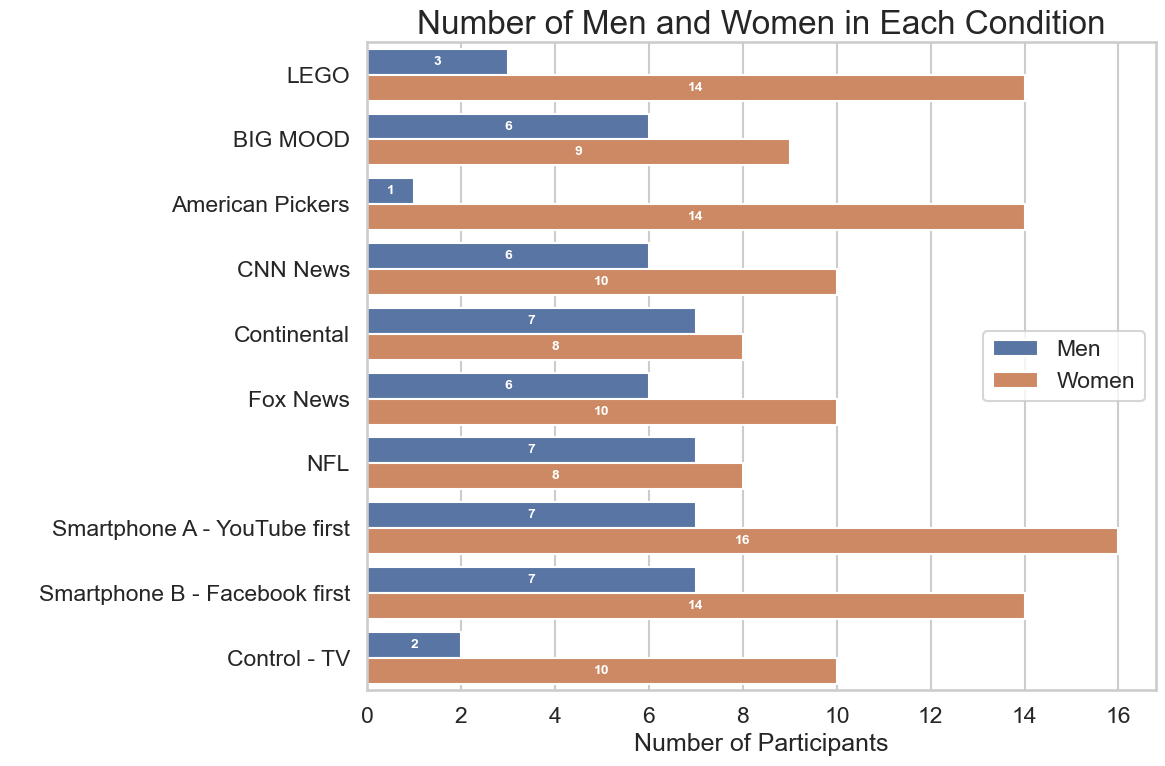

In [26]:
# Melt the dataframe to long format for seaborn
data_melted = demo_sum_filtered.melt(id_vars='cond', value_vars=['Male_Count', 'Female_Count'], var_name='gender', value_name='count')

# Create a horizontal bar plot
sns.set(style='whitegrid', context='talk')
plt.figure(figsize=(12, 8))
bars = sns.barplot(x='count', y='cond', hue='gender', data=data_melted, orient='h')

# Annotate the bars with the counts
for p in bars.patches:
    # width = p.get_width()
    # plt.text(width + 1, p.get_y() + p.get_height() / 2, f'{int(width)}', ha='center', va='center', color='black', fontsize=10)

    width = p.get_width()
    height = p.get_height()
    x = p.get_x() + width / 2
    y = p.get_y() + height / 2
    bars.annotate(f'{int(width)}', (x, y), ha='center', va='center', color='white', fontsize=10, weight='bold')

# Set custom legend labels
new_labels = ['Men', 'Women']
handles, labels = bars.get_legend_handles_labels()
bars.legend(handles, new_labels)

# Set the labels and title
plt.xlabel('Number of Participants', fontsize=18)
plt.ylabel('  ')
plt.title('Number of Men and Women in Each Condition', fontsize=24)

# Show the plot
plt.tight_layout()
plt.show()


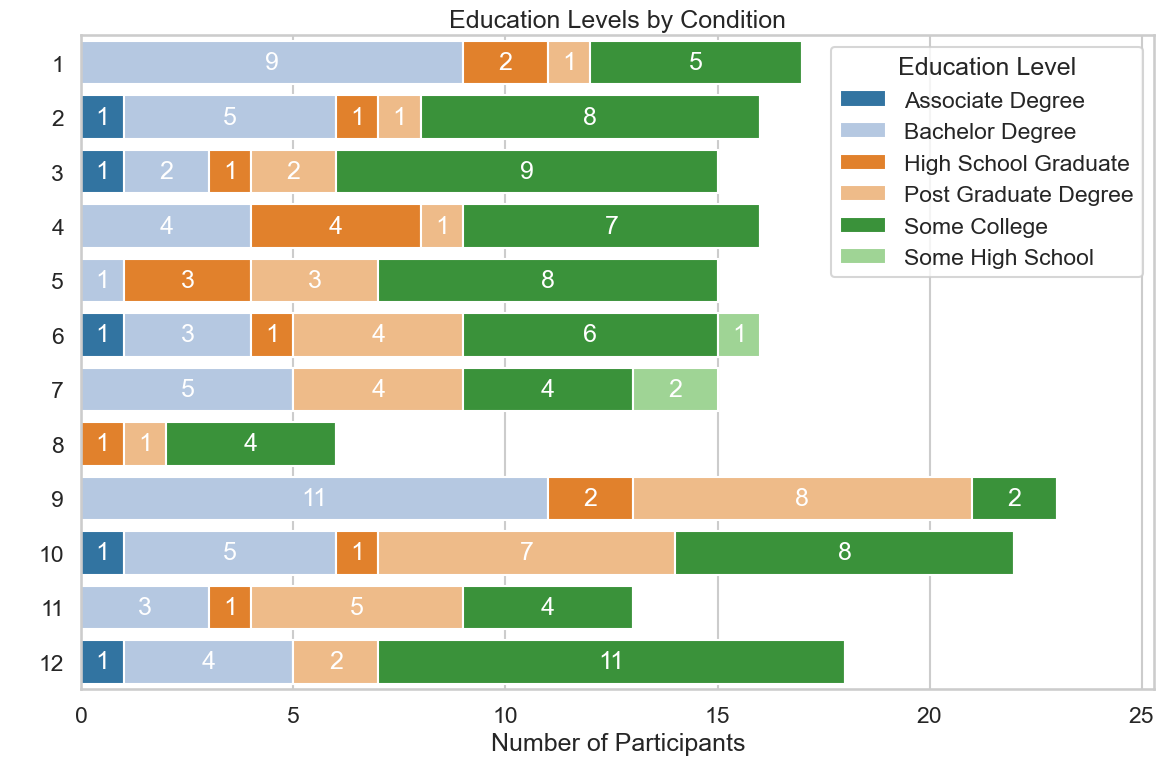

In [47]:
# Group the data by condition and education level to get the counts
education_counts = demos.groupby(['cond', 'education']).size().unstack().fillna(0)

# Prepare the data for plotting
education_counts = education_counts.reset_index()

# Calculate the maximum sum of participants in any condition
max_sum = education_counts.iloc[:, 1:].sum(axis=1).max()

custom_labels = {
    "Associate's Degree": "Associate Degree",
    "Bachelor's Degree": "Bachelor Degree",
    "High school graduate, diploma or equivalent (such as GED)": "High School Graduate",
    "Post-graduate degree (for example: Master's, JD, MD, PhD)": "Post Graduate Degree",
    "Some college credit, no degree": "Some College",
    "Some high school, no diploma": "Some High School"
}

# Plot the data using seaborn
plt.figure(figsize=(12, 8))

# Create a bar plot for each education level
bottoms = pd.Series([0] * len(education_counts['cond']))
for level in education_counts.columns[1:]:
    bar = sns.barplot(
        x=education_counts[level], 
        y=education_counts['cond'], 
        label=custom_labels.get(level, level), 
        color=sns.color_palette('tab20')[education_counts.columns[1:].tolist().index(level)],
        left=bottoms,
        orient='h'
    )
    bottoms += education_counts[level]

# Annotate the bars with the counts in the middle of each bar
for i in range(len(education_counts)):
    bottom = 0
    for j, level in enumerate(education_counts.columns[1:]):
        count = education_counts.at[i, level]
        if count > 0:
            plt.text(
                bottom + count / 2, 
                i, 
                int(count), 
                color='white', 
                ha='center', 
                va='center'
            )
        bottom += count

# Set the x-axis limit to the maximum sum of participants in any condition
plt.xlim(0, max_sum * 1.1)  # Adding some padding for better visualization

# Set the labels and title
plt.xlabel('Number of Participants')
plt.ylabel('  ')
plt.title('Education Levels by Condition')


# Customize and display the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, title='Education Level', loc='upper right') # bbox_to_anchor=(1.05, 1),


# Show the plot
plt.tight_layout()
plt.show()


In [24]:
demo_sum_flat.columns = ['cond', 'Participants', 'Age_Min', 'Age_Mean', 'Age_Max', 'Age_Std', 'Female_Count', 'Male_Count']
demo_sum_flat['Participants'].sum()
demo_sum_filtered.Participants.sum()

168

In [13]:
demos.to_csv(os.path.join(data_dir, 'demos.csv'), index=False)
demo_sum_flat.to_csv(os.path.join(data_dir, 'demos_agg.csv'), index=False)

In [9]:
from tabulate import tabulate
print(tabulate(demos_all, headers='keys', tablefmt='pretty'))

+------+-------+-------+------+
|      |  age  |   F   |  M   |
+------+-------+-------+------+
| min  | 18.0  |  nan  | nan  |
| mean | 25.63 |  nan  | nan  |
| max  | 70.0  |  nan  | nan  |
| std  | 9.94  |  nan  | nan  |
| sum  |  nan  | 129.0 | 59.0 |
+------+-------+-------+------+


### All Conditions

## Rejectors
A lot of rejectors in this group for Fox Sports and Fox News. Some still made their way into the condition they're a rejector of.

In [ ]:
rejectors = pre[['sub_id', 'Cond', 'condition', 'rejector_FOX-Prime', 'rejector_FOX-Sports', 'rejector_FOX-News']].copy()

In [ ]:
rejectors[['rejector_FOX-Prime', 'rejector_FOX-Sports', 'rejector_FOX-News']].describe()

In [ ]:
prime_miss = (rejectors['rejector_FOX-Prime']==True) & (rejectors['Cond']=='LEGO')
sports_miss = (rejectors['rejector_FOX-Sports']==True) & (rejectors['Cond']=='NFL')
news_miss = (rejectors['rejector_FOX-News']==True) & (rejectors['Cond']=='Fox News')

rejectors['miss'] = np.where(prime_miss|sports_miss|news_miss,True,False)
rejectors[(rejectors['miss']==True)]

## Willingness To Pay

In [ ]:
wtp = post.filter(regex='id|Cond|wtp')
wtp_t = post.filter(regex='id|Cond|wtp')

In [ ]:
import re

# Function to convert strings with non-numeric characters to float
def convert_to_number(value):
    if isinstance(value, str):
        # Remove non-numeric except period and minus
        cleaned_value = re.sub(r'[^\d.-]', '', value)
        # Convert to float if possible, else 0
        try:
            return float(cleaned_value)
        except ValueError:
            return 0.0
    else:
        return float(value)

In [ ]:
# Columns to clean
wtp_columns = [col for col in wtp.columns if 'wtp' in col]

# Apply the conversion
for col in wtp_columns:
    wtp[col] = wtp[col].apply(convert_to_number)

# Show the cleaned data and check types
wtp[wtp_columns].head(), wtp[wtp_columns].dtypes

In [ ]:
column_name_mapping = {
    '1_wtp_1': 'Tracfone_wtp',
    '2_wtp_1': 'Rakuten_wtp',
    '3_wtp_1': 'Paramount_wtp',
    '4_wtp_1': 'Samsung_wtp',
    '5_wtp_1': 'BurgerKing_wtp',
    '6_wtp_1': 'RedBull_wtp',
    '7_wtp_1': 'Chevrolet_wtp',
    '8_wtp_1': 'Lilly_wtp'
}

wtp.rename(columns=column_name_mapping, inplace=True)

In [ ]:
wtp_filename = f'fox-wtp_{date.strftime("%B")} {date.strftime("%-d")}, {date.strftime("%Y")}.csv' 
wtp.to_csv(os.path.join(data_dir, wtp_filename))

## Pre-Post Persuasion
??

In [40]:
top_pre = pre.filter(regex='id|top')
top_post = post.filter(regex='id|condition|top')

# top_pre.to_csv(os.path.join(data_dir, 'top_pre.csv'))
# top_post.to_csv(os.path.join(data_dir, 'top_post.csv'))

In [41]:
# Extract digits from the ID column to create a consistent key for merging
top_pre['numeric_id'] = top_pre['sub_id'].str.extract('(\d+)')
top_post['numeric_id'] = top_post['id'].str.extract('(\d+)')

# Merge the original pre and post survey data on the numeric ID column
merged_data_numeric_id = pd.merge(top_pre, top_post, on='numeric_id', suffixes=('_pre', '_post'))

merged_data_numeric_id.to_csv(os.path.join(data_dir, 'pre_post.csv'))

# Display the merged data and its dimensions
# merged_data_numeric_id.head(), merged_data_numeric_id.shape


/var/folders/4z/r7mkx_mj2d73zrgl4w0848ww0000gq/T/ipykernel_93869/2554744847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_pre['numeric_id'] = top_pre['sub_id'].str.extract('(\d+)')
/var/folders/4z/r7mkx_mj2d73zrgl4w0848ww0000gq/T/ipykernel_93869/2554744847.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_post['numeric_id'] = top_post['id'].str.extract('(\d+)')


In [47]:


# Apply the updated check for each brand and concatenate the results
updated_results_3 = pd.DataFrame()
for brand, alternatives in brand_alternatives.items():
    updated_results_3 = pd.concat([updated_results_3, check_brand_mention_updated(merged_data_numeric_id.copy(), brand, alternatives, id_col='numeric_id')], axis=1)

# Remove duplicated columns if any due to repeated merging
updated_results_3 = updated_results_3.loc[:,~updated_results_3.columns.duplicated()].copy()

# Save or display results as needed
# updated_results.to_csv('updated_top_of_mind.csv', index=False)


In [48]:
def check_brand_mention_updated(df, brand_base, alternative_names=None, id_col=None):
    pre_col = f'top_pre_{brand_base}'
    post_col = f'top_post_{brand_base}'
    brand = brand_base.split('_')[0]  # Assumes brand name is the first part of the column label
    
    # Enhance handling of alternative names or multi-word brands
    if alternative_names:
        # Create a regex pattern that matches any of the alternative names
        check_names = '|'.join([f"\\b{name}\\b" for name in alternative_names])  # \b is a word boundary in regex
    else:
        check_names = f"\\b{brand.replace('_', ' ')}\\b"  # Replace underscore with space for multi-word brands

    # Check if the brand name appears in the pre and post columns (ignoring case)
    df[f'{brand}_pre'] = df[pre_col].str.contains(check_names, na=False, case=False, regex=True)
    df[f'{brand}_post'] = df[post_col].str.contains(check_names, na=False, case=False, regex=True)
    df[f'{brand}_post_persuasion'] = (~df[f'{brand}_pre']) & (df[f'{brand}_post'])

    return df[[id_col, pre_col, post_col, f'{brand}_pre', f'{brand}_post', f'{brand}_post_persuasion']]

# Define alternative names for brands where necessary
brand_alternatives = {
    'tracfone': ['tracfone'],
    'rakuten': ['rakuten'],
    'paramount': ['paramount'],
    'samsung': ['samsung'],
    'burgerking': ['burger king'],
    'redbull': ['red bull'],
    'chevrolet': ['chevrolet'],
    'lilly': ['lilly', 'mounjaro']
}

# Apply the updated check for each brand and concatenate the results
updated_results = pd.DataFrame()
for brand, alternatives in brand_alternatives.items():
    updated_results = pd.concat([updated_results, check_brand_mention_updated(merged_data_numeric_id.copy(), brand, alternatives, id_col='numeric_id')], axis=1)

updated_results = updated_results.loc[:,~updated_results.columns.duplicated()].copy()
updated_results =  updated_results.merge(top_post[['numeric_id', 'condition']], on='numeric_id', how='left')
#updated_results.head()
# updated_results.to_csv(os.path.join(data_dir, 'top_of_mind.csv'))


In [51]:
updated_results.condition.unique()

array(['Control - Smartphone', 'LEGO', 'BIG MOOD', 'American Pickers',
       'CNN News', 'Fox News', 'NFL', 'Control - TV', 'Continental',
       'Smartphone A - YouTube first', 'Smartphone B - Facebook first',
       'YouTube - TV', nan], dtype=object)

In [52]:
tv_conditions = ['LEGO', 'BIG MOOD', 'American Pickers', 'CNN News', 'Continental', 'Fox News', 'NFL', 'Control - TV']
social_media_conditions = ['Smartphone A - YouTube first', 'Smartphone B - Facebook first']

# Columns to analyze for post persuasion
post_persuasion_columns = [col for col in updated_results.columns if 'post_persuasion' in col]

# List to store results for DataFrame conversion
results_list = []

# Function to calculate post persuasion rate and store results
def calculate_post_persuasion_rates(df_subset, condition):
    for column in post_persuasion_columns:
        # Calculate the mean of True values which represent the proportion
        rate = df_subset[column].mean()
        # Store each result as a dictionary in the results list
        results_list.append({
            'Condition': condition,
            'Brand': column.replace('_post_persuasion', ''),
            'Post_Persuasion_Rate': rate
        })

# Analyze TV conditions
for condition in tv_conditions:
    condition_data = updated_results[updated_results['condition'] == condition]  # Adjust 'condition' to your dataset's column name
    calculate_post_persuasion_rates(condition_data, condition)

# Analyze Social Media conditions
for condition in social_media_conditions:
    condition_data = updated_results[updated_results['condition'] == condition]  # Adjust 'condition' to your dataset's column name
    calculate_post_persuasion_rates(condition_data, condition)

# Convert results list to DataFrame
results_df = pd.DataFrame(results_list)

# Save the results DataFrame to a CSV file
results_df.to_csv(os.path.join(data_dir,'post_persuasion_rates.csv'), index=False)


# Scratch